# ETL Pipelines for Data Analysts

In [1]:
import pandas as pd
from prefect import task, Flow
import sqlite3
from contextlib import closing
from prefect.tasks.database.sqlite import SQLiteScript


pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Extract

In [2]:
london_path = '../data/raw/london/london_bikes.db'
seoul_path = '../data/raw/seoul/SeoulBikeData.csv'
wash_dc_path = '../data/raw/wash_dc/washington.json'
clean_path = '../data/processed/clean.parquet'
clean_db_path = '../data/processed/bikes.db'

In [3]:
@task
def extract_1(path):
    return pd.read_csv(path)

In [4]:
@task
def extract_2(path):
    conn = sqlite3.connect(path)
    query = "SELECT * FROM uk_bikes"
    return pd.read_sql_query(query, conn)

In [5]:
@task
def extract_3(path):
    return pd.read_json(path)

## Transformcolumns

## 1. Normalize Columns

In [6]:
# import sqlite3
# from contextlib import closing

# conn = sqlite3.connect("../data/raw/london/london_bikes.db")

# # c = conn.execute("""CREATE TABLE uk_bikes (
# #                     timestamp text,
# #                     cnt integer,
# #                     t1 real,
# #                     t2 real,
# #                     hum real,
# #                     wind_speed real,
# #                     weather_code real,
# #                     is_holiday real,
# #                     is_weekend real,
# #                     seasonreal real
# #                     )"""
# #                 )

# london = pd.read_csv(london_path)
# data = list(london.itertuples(name='Bikes', index=False))

# insert_cmd = "INSERT INTO uk_bikes VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"

# with closing(sqlite3.connect("london_bikes.db")) as conn:
#     with closing(conn.cursor()) as cursor:
#         cursor.executemany(insert_cmd, data)
#         conn.commit()

# c = conn.cursor()

# c.execute("SELECT * FROM uk_bikes")
# print(c.fetchmany(5))

# pd.read_sql_query("SELECT * FROM uk_bikes", conn).shape

# conn.commit()

# conn.close()

In [7]:
# @task
def change_cols(data, cols_list):
    data.columns = cols_list
    return data

In [8]:
london_cols = ['date', 'count', 'temperature', 'temp_feels_like', 'humidity', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'seasons']
seoul_cols = ['date', 'count', 'hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'seasons', 'is_holiday', 'functioning_day']
wa_dc_cols = ['instant', 'date', 'seasons', 'year', 'month', 'hour', 'is_holiday', 'weekday', 'workingday', 'weathersit', 'temperature', 'temp_feels_like', 'humidity', 'wind_speed', 'casual', 'registered', 'count']

In [9]:
# @task
def add_dates_and_location(data, city, country):
    
    data['date'] = pd.to_datetime(data['date'])
    
    data["year"] = data['date'].dt.year
    data["month"] = data['date'].dt.month
    data["week"] = data['date'].dt.isocalendar().week.astype(int)
    data["day"] = data['date'].dt.day
    data["hour"] = data['date'].dt.hour
    data["weekday"] = data['date'].dt.dayofweek
    data["is_weekend"] = (data["weekday"] > 4).astype(int)
    data['date'] = data['date'].dt.date

    data['city'] = city
    data['country'] = country
    
    return data

In [10]:
seasons_london = {0: 'Spring', 1: 'Summer', 2: 'Fall', 3: 'Winter'}
seasons_wa_dc = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
holidays_seoul = {'No Holiday': 0, 'Holiday': 1}

In [11]:
cols_drop_london = ['temp_feels_like', 'weather_code']
cols_drop_seoul = ['visibility', 'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'functioning_day']
cols_drop_wa_dc = ['instant', 'temp_feels_like', 'casual', 'registered', 'workingday', 'weathersit']

In [12]:
# @task
def fix_and_drop(data, col_to_fix, mapping, cols_to_drop):
    data[col_to_fix] = data[col_to_fix].map(mapping)
    return data.drop(cols_to_drop, axis=1)

In [13]:
# @task
def normalize_vars(data):
    data['temperature'] = data['temperature'].apply(lambda x: (x * 47) - 8)
    data['humidity'] = data['humidity'].apply(lambda x: (x / 100))
    data['wind_speed'] = data['wind_speed'].apply(lambda x: (x / 67))
    return data

In [14]:
# @task
def order_and_merge(data_lists):
    
    pick_order = data_lists[0].columns
    new_list = [d.reindex(columns=pick_order).sort_values(['date', 'hour']) for d in data_lists]
    df = pd.concat(new_list)
    return df

In [15]:
@task
def transform(london, seoul, washington):
    
    london = (london.pipe(change_cols, london_cols)
                    .pipe(add_dates_and_location, 'London', 'UK')
                    .pipe(fix_and_drop, 'seasons', seasons_london, cols_drop_london))
    
    seoul = (seoul.pipe(change_cols, seoul_cols)
                  .pipe(add_dates_and_location, 'Seoul', 'SK')
                  .pipe(fix_and_drop, 'is_holiday', holidays_seoul, cols_drop_seoul))
    
    wash_dc = (washington.pipe(change_cols, wa_dc_cols)
                         .pipe(add_dates_and_location, 'DC', 'USA')
                         .pipe(fix_and_drop, 'seasons', seasons_wa_dc, cols_drop_wa_dc)
                         .pipe(normalize_vars))
    
    return order_and_merge([london, seoul, wash_dc])
    
    # return [london, seoul, wash_dc]

In [16]:
# import sqlite3
# from contextlib import closing

# conn = sqlite3.connect("../data/raw/london/london_bikes.db")

new_table = SQLiteScript(
    db=clean_db_path,
    script="""CREATE TABLE IF NOT EXISTS bike_sharing (date text, count integer, temperature real, humidity real,
              wind_speed real, is_holiday real, is_weekend integer, seasons text, year integer,
              month integer, week integer, day integer,hour integer, weekday integer, city text,
              country text)"""
    )

# london = pd.read_csv(london_path)
# data = list(london.itertuples(name='Bikes', index=False))

# insert_cmd = "INSERT INTO uk_bikes VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"

# with closing(sqlite3.connect("london_bikes.db")) as conn:
#     with closing(conn.cursor()) as cursor:
#         cursor.executemany(insert_cmd, data)
#         conn.commit()

In [17]:
@task
def load(data, path_and_name):
    
    data = list(data.itertuples(name='Bikes', index=False))
    
    insert_cmd = "INSERT INTO bike_sharing VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
    with closing(sqlite3.connect(path_and_name)) as conn:
        with closing(conn.cursor()) as cursor:
            cursor.executemany(insert_cmd, data)
            conn.commit()

In [18]:
# @task
# def load(data, path_and_name):
#     data.to_parquet(path_and_name, compression='snappy')

In [19]:
# with Flow('bikes-ETL') as flow:
    
#     london = extract_data(london_path)
#     seoul = extract_data(seoul_path)
#     wash_dc = extract_data(wash_dc_path)
    
#     london = change_cols(london, london_cols)
#     seoul = change_cols(seoul, seoul_cols)
#     wash_dc = change_cols(wash_dc, wa_dc_cols)
    
#     london = add_dates_and_location(london, 'London', 'UK')
#     seoul = add_dates_and_location(seoul, 'Seoul', 'SK')
#     wash_dc = add_dates_and_location(wash_dc, 'DC', 'USA')
    
#     london = fix_and_drop(london, 'seasons', seasons_london, cols_drop_london)
#     seoul = fix_and_drop(seoul, 'is_holiday', holidays_seoul, cols_drop_seoul)
#     wash_dc = fix_and_drop(wash_dc, 'seasons', seasons_wa_dc, cols_drop_wa_dc)
    
#     wash_dc = normalize_vars(wash_dc)
    
#     df = order_and_merge([london, seoul, wash_dc])
    
#     load(df, clean_path)

In [20]:
with Flow('bikes-ETL') as flow:
    
    the_table = new_table()
    
    london = extract_2(london_path)
    seoul = extract_1(seoul_path)
    wash_dc = extract_3(wash_dc_path)
    
    transformed = transform(london, seoul, wash_dc)
        
    data_loaded = load(transformed, clean_db_path)
    data_loaded.set_upstream(the_table)

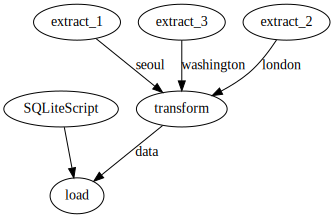

In [21]:
flow.visualize()

In [22]:
flow.run()

[2021-11-04 17:27:35+1100] INFO - prefect.FlowRunner | Beginning Flow run for 'bikes-ETL'
[2021-11-04 17:27:35+1100] INFO - prefect.TaskRunner | Task 'extract_1': Starting task run...
[2021-11-04 17:27:35+1100] INFO - prefect.TaskRunner | Task 'extract_1': Finished task run for task with final state: 'Success'
[2021-11-04 17:27:35+1100] INFO - prefect.TaskRunner | Task 'extract_3': Starting task run...
[2021-11-04 17:27:36+1100] INFO - prefect.TaskRunner | Task 'extract_3': Finished task run for task with final state: 'Success'
[2021-11-04 17:27:36+1100] INFO - prefect.TaskRunner | Task 'SQLiteScript': Starting task run...
[2021-11-04 17:27:36+1100] INFO - prefect.TaskRunner | Task 'SQLiteScript': Finished task run for task with final state: 'Success'
[2021-11-04 17:27:36+1100] INFO - prefect.TaskRunner | Task 'extract_2': Starting task run...
[2021-11-04 17:27:36+1100] INFO - prefect.TaskRunner | Task 'extract_2': Finished task run for task with final state: 'Success'
[2021-11-04 17:2

<Success: "All reference tasks succeeded.">

In [23]:
pd.read_csv(seoul_path, parse_dates=['Date'])['Date'].dt.isocalendar().week.astype(int).head()

0    2
1    2
2    2
3    2
4    2
Name: week, dtype: int64

In [24]:
pd.read_sql_query("SELECT * FROM bike_sharing", sqlite3.connect(clean_db_path)).head()

,date,count,temperature,humidity,wind_speed,is_holiday,is_weekend,seasons,year,month,week,day,hour,weekday,city,country
0,2015-01-04,182,3.0,93.0,6.0,0.0,1,Winter,2015,1,1,4,0,6,London,UK
1,2015-01-04,138,3.0,93.0,5.0,0.0,1,Winter,2015,1,1,4,1,6,London,UK
2,2015-01-04,134,2.5,96.5,0.0,0.0,1,Winter,2015,1,1,4,2,6,London,UK
3,2015-01-04,72,2.0,100.0,0.0,0.0,1,Winter,2015,1,1,4,3,6,London,UK
4,2015-01-04,47,2.0,93.0,6.5,0.0,1,Winter,2015,1,1,4,4,6,London,UK


In [25]:
pd.read_parquet(clean_path).week.describe()

count    43553.000000
mean        26.702363
std         15.053385
min          1.000000
25%         14.000000
50%         27.000000
75%         40.000000
max         53.000000
Name: week, dtype: float64